Shifted cementing file written to: Data/XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Cementing Unit_Data_shifted_minus1h2m.txt


/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_82046/4239701914.py:221: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dh_1s = dh_df.resample("1S").interpolate("time")
/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_82046/4239701914.py:222: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  cm_1s = cm_df.resample("1S").interpolate("time")
/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_82046/4239701914.py:227: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_index = pd.date_range(union_start, union_end, freq="1S")


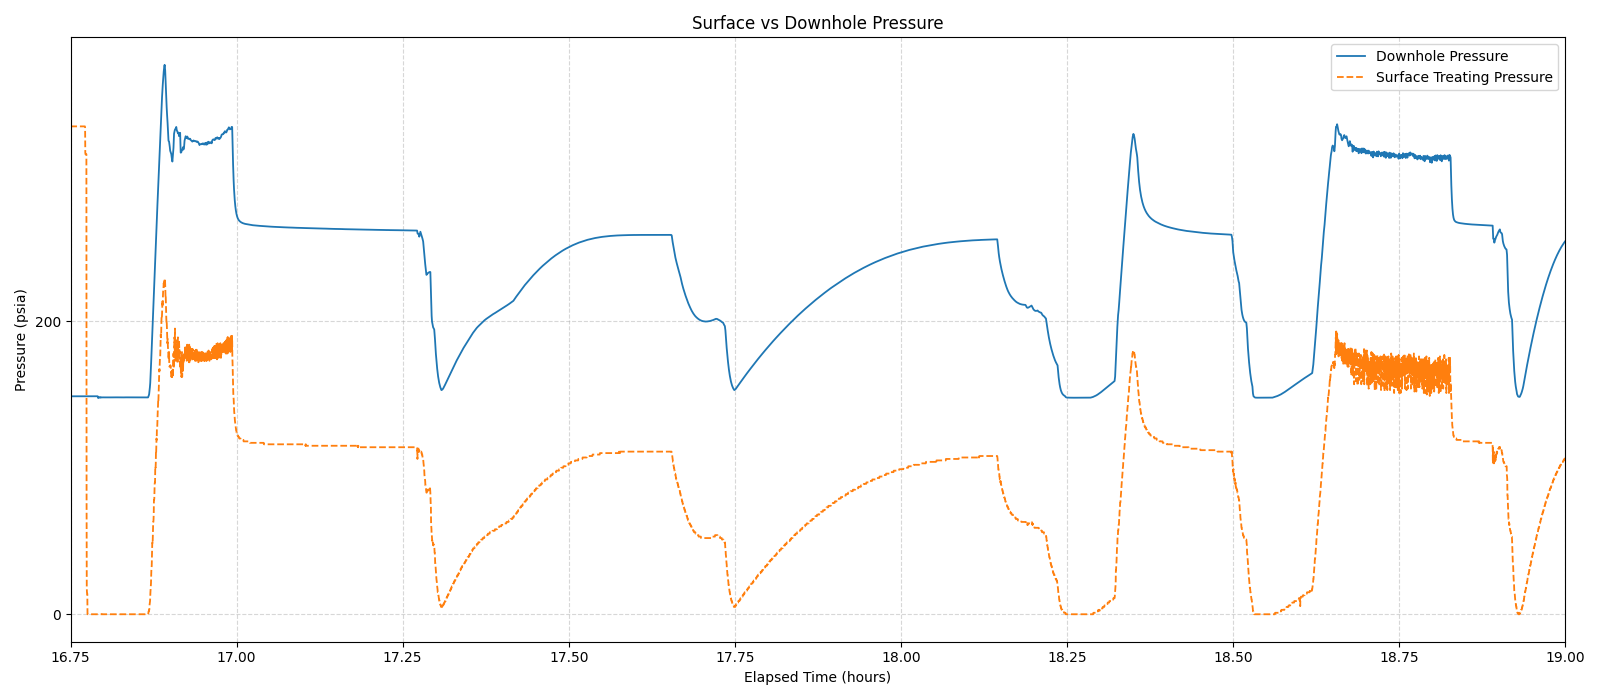

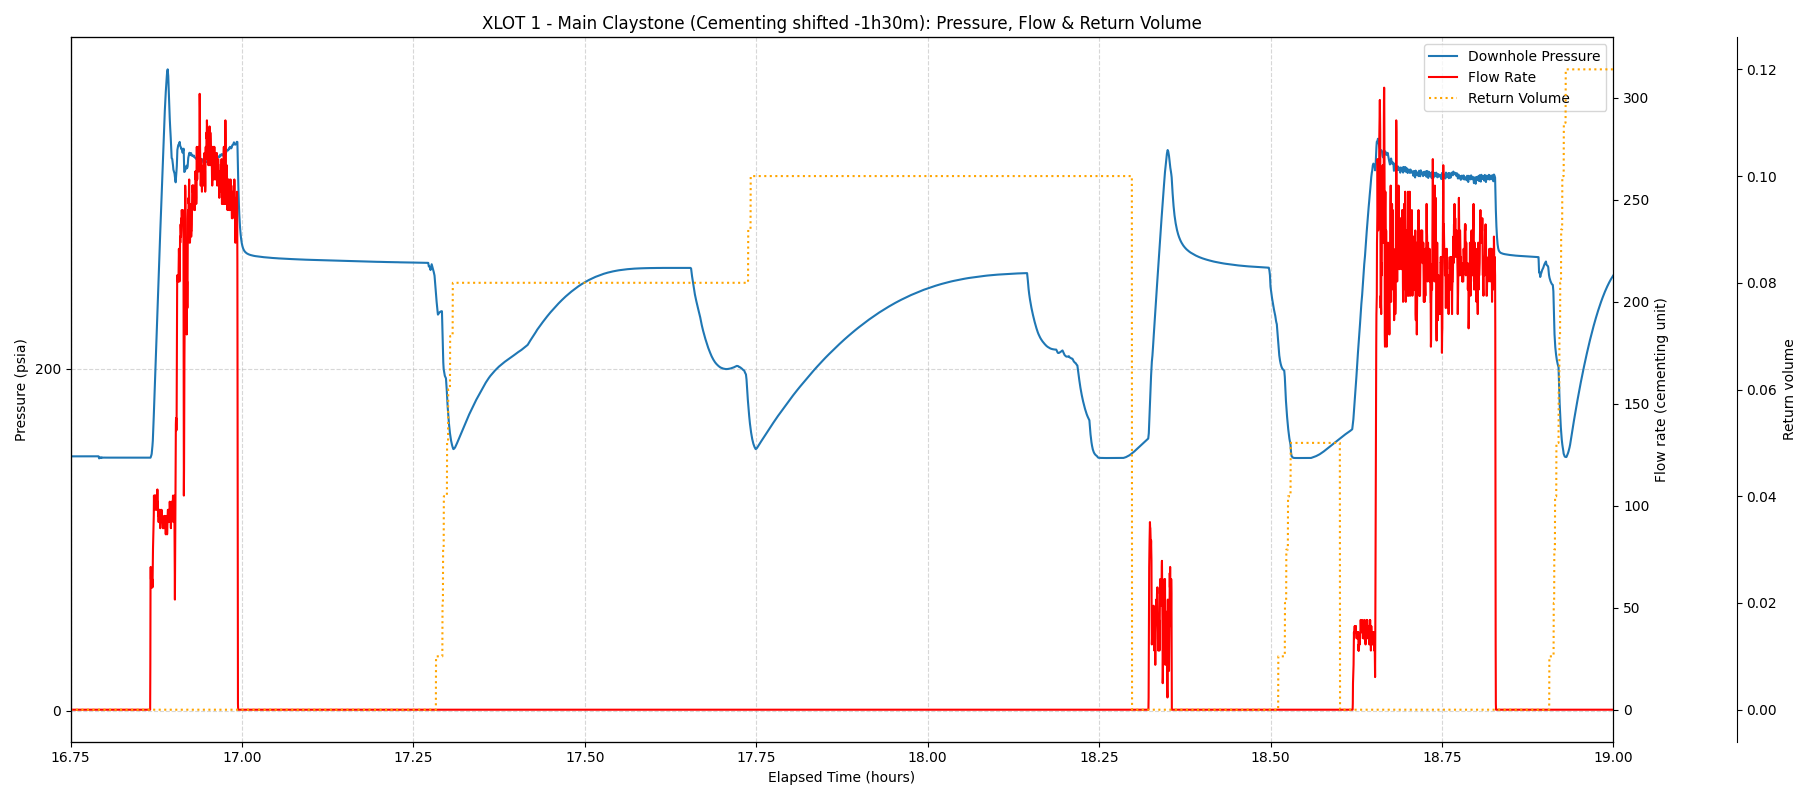

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import re
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from old_code import time_difference
from old_code import well_corrections

# ------------------------------ Config ------------------------------
base = Path("Data") 

DOWNHOLE_FILE = base / "XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Downhole Gauge_Data.TXT"
CEMENT_FILE   = base / "XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Cementing Unit_Data.txt"
SHIFT_HOURS   = 1.025277777777777  # shift earlier by 0.5 hours
OUT_SUFFIX    = "_shifted_minus1h2m"  # appended before extension

# Define time


# ----------------------------
# Hydrostatic correction to the fracture datum
# ----------------------------

# 1) Inputs you provided (replace with your true arrays/values where needed)
MD = np.array([1364, 1383, 1383.3], dtype=float)
TVD = np.array([1363.18, np.nan, 1382.31], dtype=float)  # NaN allowed; helper interpolates
TVD_fracture_m = 1866.50
gauge_index    = 1

# Surface pressure transducer is above TVD=0 by 1.46 m -> TVD down-positive
TVD_surface_sensor_m = -1.46

# Use helper to get the gauge TVD and Δz to fracture (down-positive)
TVD_interp, TVD_gauge_m, delta_tvd_gauge_to_frac_m = well_corrections.estimate_lag(
    MD, TVD, gauge_index, TVD_fracture_m
)
# Surface-to-fracture vertical distance
delta_tvd_surface_to_frac_m = TVD_fracture_m - TVD_surface_sensor_m

# 2) Unit constants
PSIA_TO_BAR = 1.0 / 14.5037738
RHO = 1000.0      # kg/m^3  (set to your actual fluid density if known)
G   = 9.80665     # m/s^2
PA_TO_BAR = 1e-5

# 3) Convert both pressure series to bar (be consistent)
combined["pressure_bar"]          = combined["pressure"] * PSIA_TO_BAR           # downhole gauge
combined["treating_pressure_bar"] = combined["treating_pressure"] * PSIA_TO_BAR  # surface treating

# 4) Hydrostatic heads to translate to the fracture datum (ignore friction for now)
dP_gauge_to_frac_bar  = (RHO * G * delta_tvd_gauge_to_frac_m)  * PA_TO_BAR
dP_surf_to_frac_bar   = (RHO * G * delta_tvd_surface_to_frac_m) * PA_TO_BAR

# If fracture is deeper than the gauge (Δz>0), bottom is higher pressure -> add head.
# General relation with TVD down-positive: P(z2) = P(z1) + ρ g (z2 - z1)

# Downhole gauge -> fracture datum
combined["P_dh_at_frac_bar"]   = combined["pressure_bar"] + dP_gauge_to_frac_bar

# Surface treating -> fracture datum (no friction term included)
combined["P_surf_at_frac_bar"] = combined["treating_pressure_bar"] + dP_surf_to_frac_bar

# ------------------------------ Utilities ------------------------------
_ts_pat = re.compile(r"^\d{2}:\d{2}:\d{4}:\d{2}:\d{2}:\d{2}$")

def to_float_smart(s):
    """
    Robust numeric parser:
      - Replace comma with dot
      - Extract numeric tokens with regex
      - Prefer tokens containing a decimal point; else take the first
    Handles strings like 'Reset Total, Vol = 0.36  m3' -> 0.36
    """
    if s is None:
        return None
    txt = str(s).strip().replace("\u00A0", " ").replace(",", ".")
    # Find all floats/ints with optional sign
    tokens = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", txt)
    if not tokens:
        return None
    # Prefer a token that includes a decimal point
    for tok in tokens:
        if "." in tok:
            try:
                return float(tok)
            except ValueError:
                continue
    # Fallback: first integer-like token
    try:
        return float(tokens[0])
    except ValueError:
        return None

def shift_cement_file_time(fp_in: Path, hours_earlier: float) -> Path:
    """
    Create a new cementing file where the timestamp in the first column
    of each data row is shifted earlier by `hours_earlier`.
    Non-data/header lines are preserved verbatim.
    """
    shift = timedelta(hours=hours_earlier)
    fp_out = fp_in.with_name(fp_in.stem + OUT_SUFFIX + fp_in.suffix)

    with open(fp_in, "r", encoding="utf-8", errors="ignore") as fin, \
         open(fp_out, "w", encoding="utf-8", errors="ignore") as fout:

        for line in fin:
            raw = line.rstrip("\n")
            parts = raw.split("\t")
            if parts and _ts_pat.fullmatch(parts[0].strip()):
                # Timestamp row: shift earlier
                try:
                    dt = datetime.strptime(parts[0].strip(), "%m:%d:%Y:%H:%M:%S")
                    new_dt = dt - shift
                    parts[0] = new_dt.strftime("%m:%d:%Y:%H:%M:%S")
                    fout.write("\t".join(parts) + "\n")
                except Exception:
                    # If parsing fails, keep the original line
                    fout.write(line)
            else:
                # Header/other lines: write unchanged
                fout.write(line)

    return fp_out

# ------------------------------ Parsers ------------------------------
def parse_downhole(path: Path) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            ln = ln.strip()
            m = re.match(
                r"(\d{2}-\d{2}-\d{4})\s+(\d{2}:\d{2}:\d{2})\s+([+-]?\d[\d,\.]*)\s+([+-]?\d[\d,\.]*)\s+([+-]?\d[\d,\.]*)",
                ln,
            )
            if not m:
                continue
            date_s, time_s, delta_s, p_s, t_s = m.groups()
            def to_float_basic(s):
                s = s.replace(" ", "").replace(",", ".")
                try:
                    return float(s)
                except ValueError:
                    return None
            rows.append({
                "timestamp": f"{date_s} {time_s}",
                "delta": to_float_basic(delta_s),
                "pressure": to_float_basic(p_s),
                "temp": to_float_basic(t_s),
            })

    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Downhole: no data recognized.")
    df["time"] = pd.to_datetime(df["timestamp"], format="%d-%m-%Y %H:%M:%S", errors="coerce")
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df[["pressure", "delta", "temp"]]

def parse_cementing_with_return_volume(path: Path) -> pd.DataFrame:
    """
    Parse cementing file expecting:
      col0 = Time  (MM:dd:YYYY:HH:MM:SS with ':')
      col1 = treating pressure (kept for compatibility)
      col2 = flow rate
      col7 = return volume (8th column) if present
    Other columns are ignored for plotting but preserved in the shifted file above.
    """
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            parts = ln.strip().split("\t")
            if not parts:
                continue
            t = parts[0].strip()
            if not _ts_pat.fullmatch(t):
                continue

            # Reformat to dd-MM-YYYY HH:MM:SS for pandas parsing
            MM, dd, yyyy, HH, MM2, SS = t.split(":")
            ts_str = f"{dd}-{MM}-{yyyy} {HH}:{MM2}:{SS}"

            treating_pressure = to_float_smart(parts[1]) if len(parts) > 1 else None
            flow_rate        = to_float_smart(parts[2]) if len(parts) > 2 else None
            return_volume    = to_float_smart(parts[7]) if len(parts) > 7 else None

            rows.append({
                "timestamp": ts_str,
                "treating_pressure": treating_pressure,
                "flow_rate": flow_rate,
                "return_volume": return_volume,
            })

    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Cementing: no data recognized.")
    df["time"] = pd.to_datetime(df["timestamp"], format="%d-%m-%Y %H:%M:%S", dayfirst=True, errors="coerce")
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df[["flow_rate", "treating_pressure", "return_volume"]]

# ------------------------------ Main ------------------------------
def main():
    
    # 1) Write shifted cementing file (timestamps 1.5 h earlier)
    shifted_fp = shift_cement_file_time(CEMENT_FILE, SHIFT_HOURS)
    print(f"Shifted cementing file written to: {shifted_fp}")

    # 2) Load downhole + shifted cementing
    dh_df = parse_downhole(DOWNHOLE_FILE)
    cm_df = parse_cementing_with_return_volume(shifted_fp)

    # De-duplicate cementing timestamps (before resampling)
    cm_df = cm_df.groupby(cm_df.index).mean(numeric_only=True)

    # Resample each dataset to 1-second grid over its OWN span
    dh_1s = dh_df.resample("1S").interpolate("time")
    cm_1s = cm_df.resample("1S").interpolate("time")

    # Build a unified 1-second index spanning the FULL union of both datasets
    union_start = min(dh_1s.index.min(), cm_1s.index.min())
    union_end   = max(dh_1s.index.max(), cm_1s.index.max())
    full_index = pd.date_range(union_start, union_end, freq="1S")

    # Align both series to the full union index (no trimming)
    dh_full = dh_1s.reindex(full_index)
    cm_full = cm_1s.reindex(full_index)

    # Combine
    combined = pd.concat(
        [dh_full[["pressure"]],
         cm_full[["flow_rate", "treating_pressure", "return_volume"]]],
        axis=1
    )

    # ---- X axis as elapsed hours from 0
    hours = (combined.index - combined.index[0]) / pd.Timedelta(hours=1)

    # ---- Plot surface vs. downhole pressure on the same axes
    fig, ax = plt.subplots(figsize=(16, 7))

    combined["pressure"] /= 14.5037738
    p_dh   = combined["pressure"]
    p_surf = combined["treating_pressure"]

    # Plot only where values exist to avoid gaps from NaNs
    mask_dh   = p_dh.notna()
    mask_surf = p_surf.notna()

    ax.plot(hours[mask_dh],   p_dh[mask_dh],   label="Downhole Pressure", linewidth=1.3)
    ax.plot(hours[mask_surf], p_surf[mask_surf], label="Surface Treating Pressure", linewidth=1.3, linestyle="--")

    ax.set_xlabel("Elapsed Time (hours)")
    ax.set_ylabel("Pressure (psia)")
    ax.set_title("Surface vs Downhole Pressure")

    # Grid & locators
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(200))
    ax.grid(True, which="major", axis="both", linestyle="--", alpha=0.5)

    # Match time range of previous figure (15–22h, cropped to 16.75–19)
    ax.set_xlim(16.75, 19)

    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    # Plot
    fig, ax1 = plt.subplots(figsize=(18, 8))

    # Left y-axis: pressure
    line1, = ax1.plot(hours, combined["pressure"], label="Downhole Pressure")
    ax1.set_xlabel("Elapsed Time (hours)")
    ax1.set_ylabel("Pressure (psia)")

    # Grid: vertical every 0.25 h, horizontal every 200 psia
    ax1.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
    ax1.yaxis.set_major_locator(mticker.MultipleLocator(200))
    ax1.grid(True, which="major", axis="both", linestyle="--", alpha=0.5)

    # Right y-axis (1): flow rate
    ax2 = ax1.twinx()
    line2, = ax2.plot(hours, combined["flow_rate"], label="Flow Rate", color='red')
    ax2.set_ylabel("Flow rate (cementing unit)")

    # Right y-axis (2): return volume (offset spine)
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.08))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)
    line3, = ax3.plot(hours, combined["return_volume"], label="Return Volume",
                      linestyle=":", color="orange")
    ax3.set_ylabel("Return volume")

    # Crop view to 15–22 hours (plot only)
    ax1.set_xlim(16.75, 19)

    # Legend combining all three
    lines = [line1, line2, line3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper right")

    plt.title("XLOT 1 - Main Claystone (Cementing shifted -1h30m): Pressure, Flow & Return Volume")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Shifted cementing file written to: Data/XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Cementing Unit_Data_shifted_minus1h2m.txt


/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_82046/3804153129.py:148: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dh_1s = dh_df.resample("1S").interpolate("time")
/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_82046/3804153129.py:149: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  cm_1s = cm_df.resample("1S").interpolate("time")
/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_82046/3804153129.py:154: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_index = pd.date_range(union_start, union_end, freq="1S")


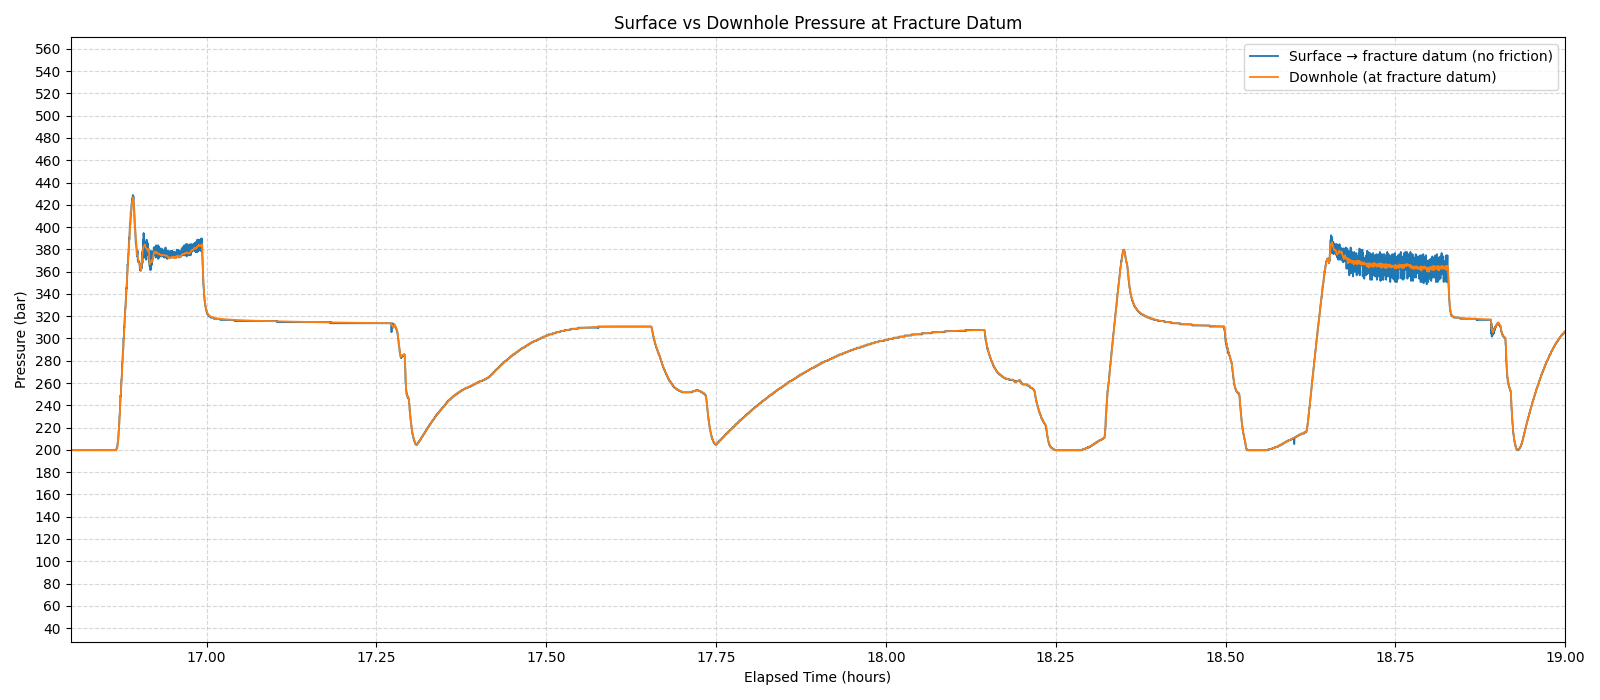

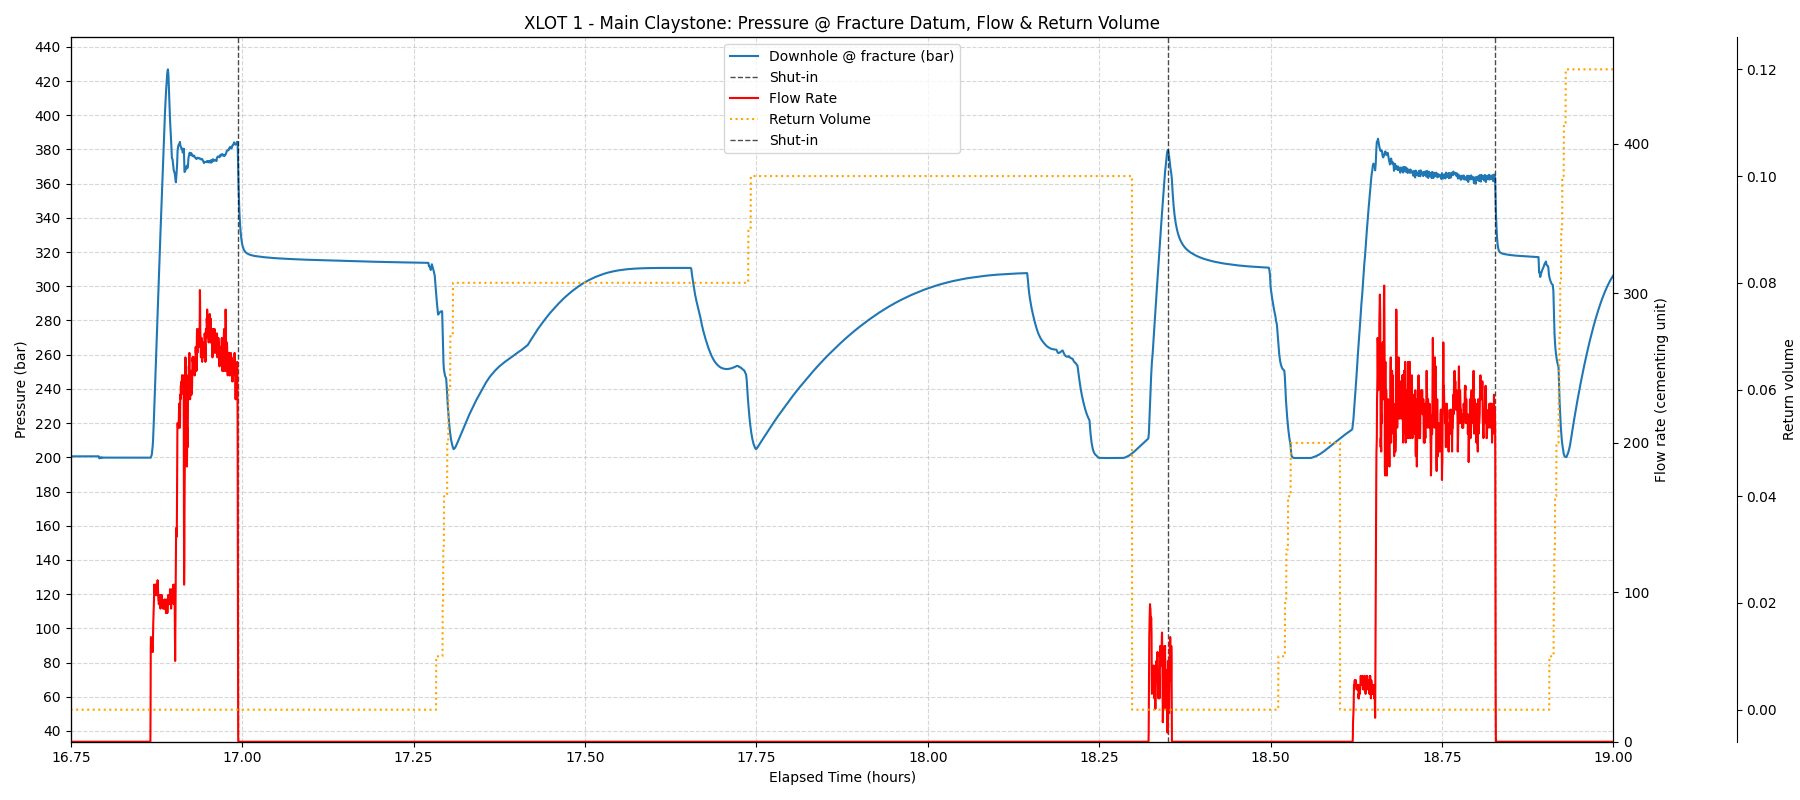

In [75]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import re
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from old_code import time_difference
from old_code import well_corrections

%matplotlib widget

# ------------------------------ Config ------------------------------
base = Path("Data")

DOWNHOLE_FILE = base / "XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Downhole Gauge_Data.TXT"
CEMENT_FILE   = base / "XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Cementing Unit_Data.txt"
SHIFT_HOURS   = 1.025277777777777
OUT_SUFFIX    = "_shifted_minus1h2m"  # appended before extension

# Time window




# ------------------------------ Utilities ------------------------------
_ts_pat = re.compile(r"^\d{2}:\d{2}:\d{4}:\d{2}:\d{2}:\d{2}$")

def to_float_smart(s):
    if s is None:
        return None
    txt = str(s).strip().replace("\u00A0", " ").replace(",", ".")
    tokens = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", txt)
    if not tokens:
        return None
    for tok in tokens:
        if "." in tok:
            try:
                return float(tok)
            except ValueError:
                continue
    try:
        return float(tokens[0])
    except ValueError:
        return None

def shift_cement_file_time(fp_in: Path, hours_earlier: float) -> Path:
    shift = timedelta(hours=hours_earlier)
    fp_out = fp_in.with_name(fp_in.stem + OUT_SUFFIX + fp_in.suffix)
    with open(fp_in, "r", encoding="utf-8", errors="ignore") as fin, \
         open(fp_out, "w", encoding="utf-8", errors="ignore") as fout:
        for line in fin:
            raw = line.rstrip("\n")
            parts = raw.split("\t")
            if parts and _ts_pat.fullmatch(parts[0].strip()):
                try:
                    dt = datetime.strptime(parts[0].strip(), "%m:%d:%Y:%H:%M:%S")
                    new_dt = dt - shift
                    parts[0] = new_dt.strftime("%m:%d:%Y:%H:%M:%S")
                    fout.write("\t".join(parts) + "\n")
                except Exception:
                    fout.write(line)
            else:
                fout.write(line)
    return fp_out

# ------------------------------ Parsers ------------------------------
def parse_downhole(path: Path) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            ln = ln.strip()
            m = re.match(
                r"(\d{2}-\d{2}-\d{4})\s+(\d{2}:\d{2}:\d{2})\s+([+-]?\d[\d,\.]*)\s+([+-]?\d[\d,\.]*)\s+([+-]?\d[\d,\.]*)",
                ln,
            )
            if not m:
                continue
            date_s, time_s, delta_s, p_s, t_s = m.groups()
            def to_float_basic(s):
                s = s.replace(" ", "").replace(",", ".")
                try:
                    return float(s)
                except ValueError:
                    return None
            rows.append({
                "timestamp": f"{date_s} {time_s}",
                "delta": to_float_basic(delta_s),
                "pressure": to_float_basic(p_s),
                "temp": to_float_basic(t_s),
            })
    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Downhole: no data recognized.")
    df["time"] = pd.to_datetime(df["timestamp"], format="%d-%m-%Y %H:%M:%S", errors="coerce")
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df[["pressure", "delta", "temp"]]

def parse_cementing_with_return_volume(path: Path) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            parts = ln.strip().split("\t")
            if not parts:
                continue
            t = parts[0].strip()
            if not _ts_pat.fullmatch(t):
                continue
            MM, dd, yyyy, HH, MM2, SS = t.split(":")
            ts_str = f"{dd}-{MM}-{yyyy} {HH}:{MM2}:{SS}"
            treating_pressure = to_float_smart(parts[1]) if len(parts) > 1 else None
            flow_rate        = to_float_smart(parts[2]) if len(parts) > 2 else None
            volume           = to_float_smart(parts[4]) if len(parts) > 4 else None   # <— pumped volume (normal)
            return_volume    = to_float_smart(parts[7]) if len(parts) > 7 else None

            rows.append({
                "timestamp": ts_str,
                "treating_pressure": treating_pressure,
                "flow_rate": flow_rate,
                "volume": volume,                  # <—
                "return_volume": return_volume,
            })
    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Cementing: no data recognized.")
    df["time"] = pd.to_datetime(df["timestamp"], format="%d-%m-%Y %H:%M:%S", dayfirst=True, errors="coerce")
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df[["flow_rate", "treating_pressure", "volume", "return_volume"]]



# 1) Write shifted cementing file (timestamps shifted earlier)
shifted_fp = shift_cement_file_time(CEMENT_FILE, SHIFT_HOURS)
print(f"Shifted cementing file written to: {shifted_fp}")

# 2) Load downhole + shifted cementing
dh_df = parse_downhole(DOWNHOLE_FILE)
cm_df = parse_cementing_with_return_volume(shifted_fp)

# De-duplicate cementing timestamps (before resampling)
cm_df = cm_df.groupby(cm_df.index).mean(numeric_only=True)

# Resample each dataset to 1-second grid over its OWN span
dh_1s = dh_df.resample("1S").interpolate("time")
cm_1s = cm_df.resample("1S").interpolate("time")

# Build a unified 1-second index spanning the FULL union of both datasets
union_start = min(dh_1s.index.min(), cm_1s.index.min())
union_end   = max(dh_1s.index.max(), cm_1s.index.max())
full_index = pd.date_range(union_start, union_end, freq="1S")

# Align both series to the full union index (no trimming)
dh_full = dh_1s.reindex(full_index)
cm_full = cm_1s.reindex(full_index)

# Combine
combined = pd.concat(
    [dh_full[["pressure"]],
     cm_full[["flow_rate", "treating_pressure", "volume", "return_volume"]]],
    axis=1
)

# ---- X axis as elapsed hours from 0
hours = (combined.index - combined.index[0]) / pd.Timedelta(hours=1)

# ----------------------------
# Hydrostatic correction to FRACTURE datum
# ----------------------------

# (A) Geometry / sensor positions (replace with your true arrays if needed)
MD = np.array([1364, 1383, 1383.3], dtype=float)
TVD = np.array([1363.18, np.nan, 1382.31], dtype=float)  # NaN OK; helper interpolates
TVD_fracture_m = 1866.50
gauge_index    = 1
TVD_surface_sensor_m = -1.46   # surface transducer above TVD=0 by 1.46 m

# (B) Use helper to get positions and ΔTVDs (down-positive)
TVD_interp, TVD_gauge_m, delta_tvd_gauge_to_frac_m = well_corrections.estimate_lag(
    MD, TVD, gauge_index, TVD_fracture_m
)
delta_tvd_surface_to_frac_m = TVD_fracture_m - TVD_surface_sensor_m

# (C) Unit constants
PSIA_TO_BAR = 1.0 / 14.5037738
RHO = 1090     # kg/m^3  <-- set this to your actual fluid density
G   = 9.80665    # m/s^2
PA_TO_BAR = 1e-5

# (D) Convert both pressure series to bar
combined["pressure_bar"]          = combined["pressure"] * PSIA_TO_BAR
combined["treating_pressure_bar"] = combined["treating_pressure"] 

# (E) Hydrostatic head to translate to fracture datum (ignore friction for now)
dP_gauge_to_frac_bar = (RHO * G * delta_tvd_gauge_to_frac_m)  * PA_TO_BAR
dP_surf_to_frac_bar  = (RHO * G * delta_tvd_surface_to_frac_m) * PA_TO_BAR

# Downhole gauge -> fracture datum (add head if fracture deeper)
combined["P_dh_at_frac_bar"]   = combined["pressure_bar"] + dP_gauge_to_frac_bar
# Surface treating -> fracture datum (no friction term)
combined["P_surf_at_frac_bar"] = combined["treating_pressure_bar"] + dP_surf_to_frac_bar

# ----------------------------
# Plot 1: Surface vs Downhole (both at fracture datum, in bar)
# ----------------------------
fig, ax = plt.subplots(figsize=(16, 7))

p_dh_frac   = combined["P_dh_at_frac_bar"]
p_surf_frac = combined["P_surf_at_frac_bar"]
mask1 = p_dh_frac.notna()
mask2 = p_surf_frac.notna()

ax.plot(hours[mask2], p_surf_frac[mask2], label="Surface → fracture datum (no friction)", linewidth=1.3)
ax.plot(hours[mask1], p_dh_frac[mask1],   label="Downhole (at fracture datum)", linewidth=1.3)

ax.set_xlabel("Elapsed Time (hours)")
ax.set_ylabel("Pressure (bar)")
ax.set_title("Surface vs Downhole Pressure at Fracture Datum")
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
ax.yaxis.set_major_locator(mticker.MultipleLocator(20))
ax.grid(True, which="major", axis="both", linestyle="--", alpha=0.5)
ax.set_xlim(16.8, 19)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

# ----------------------------
# Plot 2: Pressure (downhole at fracture datum) + Flow + Return Volume
# ----------------------------

# 4) Auto + manual shut-in times (supports multiple manuals)
USE_MANUAL_SHUTIN      = True
MANUAL_SHUTINS_SURFACE = [
    16.99333,
    18.35,
    18.8275
]  # set to [] or None to skip

fig, ax1 = plt.subplots(figsize=(18, 8))

line1, = ax1.plot(hours, combined["P_dh_at_frac_bar"], label="Downhole @ fracture (bar)")
ax1.set_xlabel("Elapsed Time (hours)")
ax1.set_ylabel("Pressure (bar)")
ax1.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
ax1.yaxis.set_major_locator(mticker.MultipleLocator(20))
ax1.grid(True, which="major", axis="both", linestyle="--", alpha=0.5)

ax2 = ax1.twinx()
line2, = ax2.plot(hours, combined["flow_rate"], label="Flow Rate", color='red')
ax2.set_ylabel("Flow rate (cementing unit)")

# --- Rescale the flowrate y-axis (no value modification) ---
max_flow = np.nanmax(combined["flow_rate"])
ax2.set_ylim(0, 1.5 * max_flow)
# ------------------------------------------------------------

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.08))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
line3, = ax3.plot(hours, combined["return_volume"], label="Return Volume",
                    linestyle=":", color="orange")
ax3.set_ylabel("Return volume")

# ------------------------------------------------------------------
# Add vertical dashed lines for manual shut-ins (with label for legend)
# ------------------------------------------------------------------
shutin_line = None
if USE_MANUAL_SHUTIN and MANUAL_SHUTINS_SURFACE:
    t0 = combined.index[0]
    first_label_added = False  # only add one legend entry
    for i, ts in enumerate(MANUAL_SHUTINS_SURFACE, start=1):
        try:
            if isinstance(ts, (int, float, np.floating)):
                shut_hr = float(ts)
            else:
                shut_dt = pd.to_datetime(ts)
                shut_hr = (shut_dt - t0) / pd.Timedelta(hours=1)

            ln = ax1.axvline(
                shut_hr,
                color="k",
                linestyle="--",
                linewidth=1,
                alpha=0.7,
                label="Shut-in" if not first_label_added else None,
            )
            if not first_label_added:
                shutin_line = ln
                first_label_added = True
        except Exception as e:
            print(f"Warning: could not parse shut-in time '{ts}': {e}")

# ------------------------------------------------------------------
# Rescale flowrate axis (no rescaling of data)
# ------------------------------------------------------------------
max_flow = np.nanmax(combined["flow_rate"])
ax2.set_ylim(0, 1.5 * max_flow)
# ------------------------------------------------------------------

# X limits
ax1.set_xlim(16.75, 19)

# ------------------------------------------------------------------
# Combine legend entries from all three axes (pressure, flowrate, return volume, shut-ins)
# ------------------------------------------------------------------
lines = []
labels = []

# Collect handles/labels from all axes
for ax in (ax1, ax2, ax3):
    ln, lb = ax.get_legend_handles_labels()
    lines.extend(ln)
    labels.extend(lb)

# Add shut-in if drawn
if shutin_line is not None:
    lines.append(shutin_line)
    labels.append("Shut-in")

# Make combined legend
ax1.legend(lines, labels, loc="upper center")

plt.title("XLOT 1 - Main Claystone: Pressure @ Fracture Datum, Flow & Return Volume")
plt.tight_layout()
plt.show()



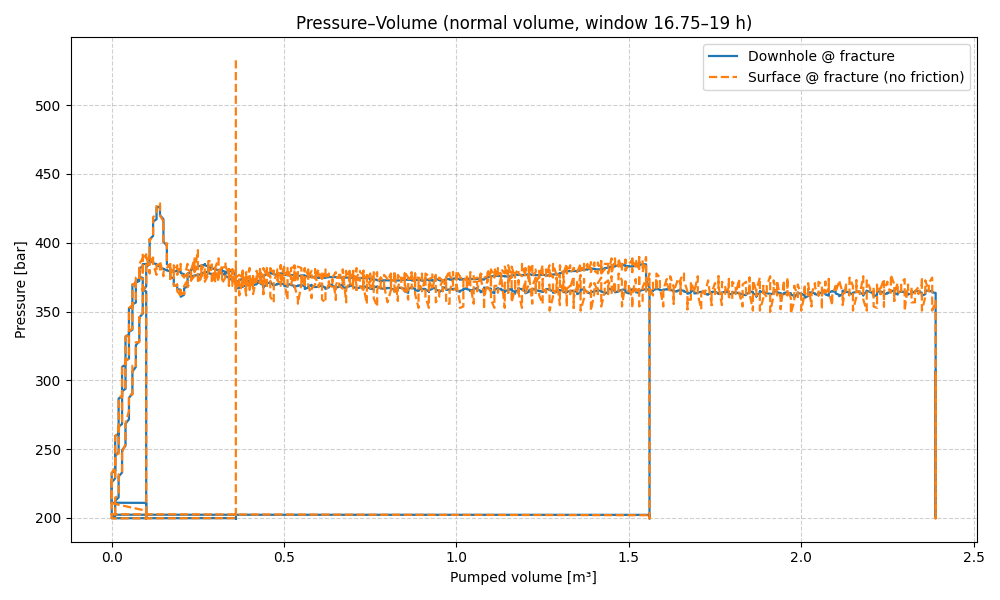

In [76]:
# ----------------------------
# Pressure vs Normal Volume (window 16.75–19 h)
# ----------------------------
mask_window = (hours >= 16.75) & (hours <= 19)

V = combined.loc[mask_window, "volume"]
P_dh = combined.loc[mask_window, "P_dh_at_frac_bar"]
P_sf = combined.loc[mask_window, "P_surf_at_frac_bar"]

df_pv = pd.DataFrame({"V": V, "P_dh": P_dh, "P_sf": P_sf}).dropna()

figPV, axPV = plt.subplots(figsize=(10, 6))
axPV.plot(df_pv["V"], df_pv["P_dh"], label="Downhole @ fracture", lw=1.6)
axPV.plot(df_pv["V"], df_pv["P_sf"], label="Surface @ fracture (no friction)", lw=1.6, linestyle="--")

axPV.set_xlabel("Pumped volume [m³]")
axPV.set_ylabel("Pressure [bar]")
axPV.set_title("Pressure–Volume (normal volume, window 16.75–19 h)")
axPV.grid(True, which="both", linestyle="--", alpha=0.6)
axPV.legend(loc="best")

plt.tight_layout()
plt.show()

Detected 4 cycles.


,start_idx,end_idx,t_start,t_end,duration,start_value,end_value,samples
0,58790,60470,2023-12-10 13:43:59,2023-12-10 14:11:59,0 days 00:28:00,0.0,0.00,1681
1,60723,65873,2023-12-10 14:16:12,2023-12-10 15:42:02,0 days 01:25:50,0.0,0.00,5151
2,65965,66965,2023-12-10 15:43:34,2023-12-10 16:00:14,0 days 00:16:40,0.0,0.00,1001
3,67042,68857,2023-12-10 16:01:31,2023-12-10 16:31:46,0 days 00:30:15,0.0,2.39,1816


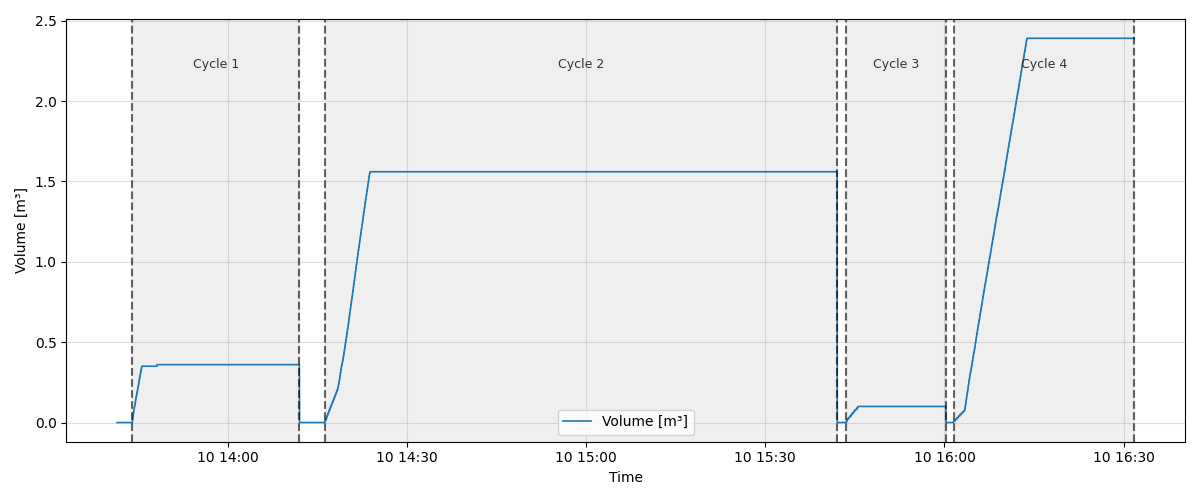

In [77]:
import numpy as np
import pandas as pd

def detect_volume_cycles(volume, tol=1e-3,
                         include_last_partial=True,
                         skip_all_zero_leading=True):
    """
    Detect pumping cycles from a 'normal' volume signal.

    - Cycle starts at the last near-zero sample before volume rises.
    - Cycle ends at the first near-zero sample after pumping stops.
    - If there is no trailing zero and include_last_partial=True, the cycle ends
      at the last *valid* (non-NaN) volume sample.
    - Optionally skip a leading all-zero "cycle".
    """
    v = pd.Series(volume, copy=False).astype(float)
    idx = v.index

    # Where data exists
    notna = v.notna().values
    if not notna.any():
        # no valid samples at all
        return pd.DataFrame(columns=[
            "start_idx","end_idx","t_start","t_end","duration",
            "start_value","end_value","samples"
        ])

    last_valid_idx = int(np.flatnonzero(notna)[-1])

    # Zero/nonzero classification only on valid samples; NaNs are neither pumping nor zero
    is_zero = (v.fillna(np.inf) < tol)    # NaNs -> False here

    # Transitions (evaluate on valid samples implicitly by the shift logic)
    start_boundary = is_zero.shift(1, fill_value=False) & (~is_zero)   # zero → nonzero
    end_boundary   = (~is_zero.shift(1, fill_value=False)) & (is_zero) # nonzero → zero

    start_idx = np.flatnonzero(start_boundary.values)
    end_idx   = np.flatnonzero(end_boundary.values)

    cycles = []
    s_ptr, e_ptr = 0, 0

    while s_ptr < len(start_idx):
        s_i = start_idx[s_ptr]
        # Start at the LAST zero before the rise
        t_start_i = max(0, s_i - 1)

        # Advance end pointer to first end AFTER start
        while e_ptr < len(end_idx) and end_idx[e_ptr] <= t_start_i:
            e_ptr += 1

        if e_ptr < len(end_idx):
            t_end_i = end_idx[e_ptr]
            e_ptr += 1
        else:
            # No zero found after start → use last valid sample if allowed
            if include_last_partial:
                t_end_i = last_valid_idx
            else:
                break

        # Clip end to last valid index to satisfy "stops when there are no volume values anymore"
        t_end_i = min(t_end_i, last_valid_idx)

        if t_end_i > t_start_i:
            cycles.append((t_start_i, t_end_i))

        # Move to next start after this end
        while s_ptr < len(start_idx) and start_idx[s_ptr] <= t_end_i:
            s_ptr += 1

    # Drop a leading all-zero cycle if requested
    if skip_all_zero_leading and cycles:
        s0, e0 = cycles[0]
        if np.nanmax(v.iloc[s0:e0+1].values) < tol:
            cycles = cycles[1:]

    # Build result table
    rows = []
    for s_i, e_i in cycles:
        t_start = idx[s_i]
        t_end   = idx[e_i]
        duration = (pd.to_datetime(t_end) - pd.to_datetime(t_start)
                    if isinstance(idx, pd.DatetimeIndex) else float(e_i - s_i))
        rows.append({
            "start_idx": int(s_i),
            "end_idx":   int(e_i),
            "t_start":   t_start,
            "t_end":     t_end,
            "duration":  duration,
            "start_value": float(v.iloc[s_i]),
            "end_value":   float(v.iloc[e_i]),
            "samples":   int(e_i - s_i + 1),
        })

    return pd.DataFrame(rows)

cycles_df = detect_volume_cycles(
    combined["volume"],
    tol=1e-3,
    include_last_partial=True,     # keep final partial
    skip_all_zero_leading=True     # drop initial all-zero
)
print(f"Detected {len(cycles_df)} cycles.")
display(cycles_df)

# Visual check with labeled regions
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(combined.index, combined["volume"], label="Volume [m³]", lw=1.2)

for i, cyc in enumerate(cycles_df.itertuples(index=False), start=1):
    ax.axvline(cyc.t_start, color="k", ls="--", alpha=0.6)
    ax.axvline(cyc.t_end,   color="k", ls="--", alpha=0.6)
    ax.axvspan(cyc.t_start, cyc.t_end, color="grey", alpha=0.12)
    y_top = np.nanmax(combined["volume"].values)
    t_mid = pd.to_datetime(cyc.t_start) + (pd.to_datetime(cyc.t_end) - pd.to_datetime(cyc.t_start))/2
    ax.text(t_mid, 0.95*y_top if np.isfinite(y_top) else 0.0,
            f"Cycle {i}", ha="center", va="top", fontsize=9, color="0.2")

ax.set_ylabel("Volume [m³]")
ax.set_xlabel("Time")
ax.legend()
ax.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

Detected 3 cycles from volume zeros.


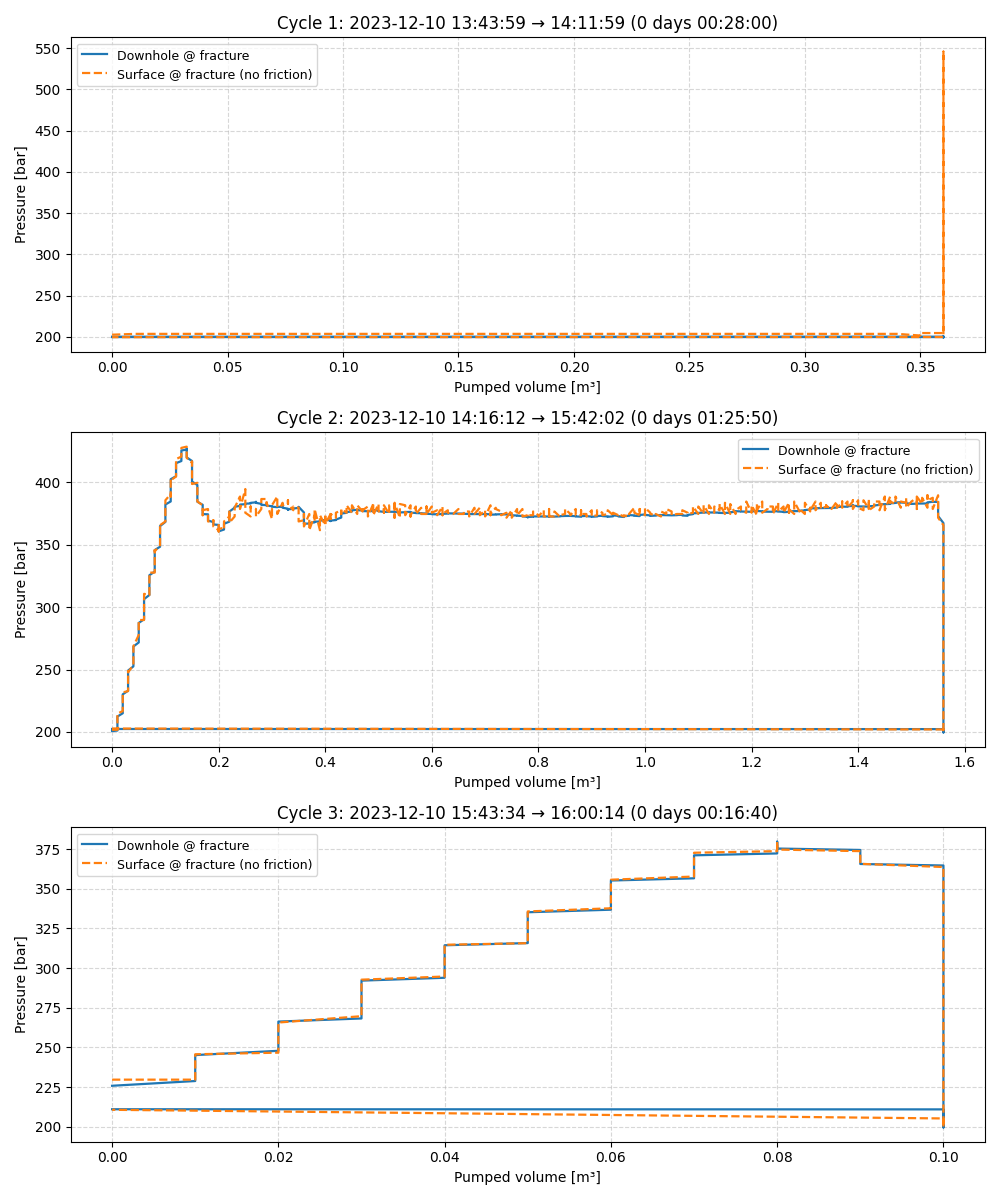

In [78]:
# ============================
# Plot Pressure vs Volume for each detected cycle
# ============================

def detect_volume_cycles(volume, tol=1e-3, drop_partial_leading=True):
    """
    Identify complete pumping cycles from a 'normal' or cumulative volume signal.
    Each cycle:
      - starts at the last near-zero sample before pumping rises
      - ends at the first near-zero sample after pumping stops
    """
    v = pd.Series(volume).astype(float)
    idx = v.index

    is_zero = v < tol
    start_boundary = is_zero.shift(1, fill_value=False) & (~is_zero)   # zero → nonzero
    end_boundary   = (~is_zero.shift(1, fill_value=False)) & is_zero   # nonzero → zero

    start_idx = np.flatnonzero(start_boundary.values)
    end_idx   = np.flatnonzero(end_boundary.values)

    cycles = []
    s_ptr, e_ptr = 0, 0

    # Optionally skip partial leading cycle if we start mid-pumping
    if not is_zero.iloc[0] and drop_partial_leading and len(end_idx) > 0:
        while s_ptr < len(start_idx) and start_idx[s_ptr] < end_idx[0]:
            s_ptr += 1

    while s_ptr < len(start_idx):
        s_i = start_idx[s_ptr]
        t_start_i = max(0, s_i - 1)  # last zero before the rise
        while e_ptr < len(end_idx) and end_idx[e_ptr] <= t_start_i:
            e_ptr += 1
        if e_ptr >= len(end_idx):
            break  # no closing zero → incomplete cycle
        t_end_i = end_idx[e_ptr]
        e_ptr += 1
        if t_end_i > t_start_i:
            cycles.append((t_start_i, t_end_i))
        s_ptr += 1

    rows = []
    for s_i, e_i in cycles:
        t_start = idx[s_i]
        t_end   = idx[e_i]
        dur = (pd.to_datetime(t_end) - pd.to_datetime(t_start)
               if isinstance(idx, pd.DatetimeIndex)
               else float(e_i - s_i))
        rows.append({
            "start_idx": s_i, "end_idx": e_i,
            "t_start": t_start, "t_end": t_end,
            "duration": dur,
            "start_value": float(v.iloc[s_i]),
            "end_value": float(v.iloc[e_i]),
            "samples": int(e_i - s_i + 1),
        })
    return pd.DataFrame(rows)

# 1) Detect cycles from the volume series
cycles_df = detect_volume_cycles(combined["volume"], tol=1e-3, drop_partial_leading=True)
print(f"Detected {len(cycles_df)} cycles from volume zeros.")

if len(cycles_df) == 0:
    print("No complete cycles detected; nothing to plot.")
else:
    # 2) Make one subplot per cycle
    n = len(cycles_df)
    fig, axes = plt.subplots(n, 1, figsize=(10, 4*n), squeeze=False)
    axes = axes.ravel()

    for k, (_, cyc) in enumerate(cycles_df.iterrows()):
        ax = axes[k]
        s_i = int(cyc["start_idx"])
        e_i = int(cyc["end_idx"])

        # Slice the time-aligned data for this cycle
        df_cyc = combined.iloc[s_i:e_i+1][["volume", "P_dh_at_frac_bar", "P_surf_at_frac_bar"]].dropna()

        if df_cyc.empty:
            ax.text(0.5, 0.5, "No data in this cycle", ha="center", va="center", transform=ax.transAxes)
            ax.set_axis_off()
            continue

        # Plot pressure vs (instantaneous) volume
        ax.plot(df_cyc["volume"], df_cyc["P_dh_at_frac_bar"], lw=1.6, label="Downhole @ fracture")
        ax.plot(df_cyc["volume"], df_cyc["P_surf_at_frac_bar"], lw=1.6, ls="--", label="Surface @ fracture (no friction)")

        # Labels & title per cycle
        t0 = pd.to_datetime(cyc["t_start"])
        t1 = pd.to_datetime(cyc["t_end"])
        ax.set_xlabel("Pumped volume [m³]")
        ax.set_ylabel("Pressure [bar]")
        ax.set_title(f"Cycle {k+1}: {t0.strftime('%Y-%m-%d %H:%M:%S')} → {t1.strftime('%H:%M:%S')} "
                     f"({str(cyc['duration'])})")
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        ax.legend(loc="best", fontsize=9)

    plt.tight_layout()
    plt.show()

In [79]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
XLOT 2 - Vlieland Claystone
Absolute-time alignment of Downhole Pressure (left y-axis)
and Cementing Unit Flow Rate + Return Rate (right y-axes), 1-second grid.

- X axis: elapsed hours from 0 (full union of time ranges)
- Grid: vertical every 0.25 h, horizontal every 200 psia
- Return RATE (L/min) comes from column 7 of the cementing file (index 6)
- No axis crop applied (you can set CROP_X_LIMS if desired)
- SHIFT_HOURS = 0.0 by default (change to shift cementing times earlier/later)
"""

import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ------------------------------ Config ------------------------------
base = Path("Data") 

DOWNHOLE_FILE = base / "XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 2 - Vlieland Claystone_Cementing Unit_Data.txt"
CEMENT_FILE   = base / "XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 2 - Vlieland Claystone_Downhole Gauge_Data.TXT"

SHIFT_HOURS   = -1.005# +value => shift CEMENTING earlier by that many hours; 0.0 leaves as-is
CROP_X_LIMS   = (12.5,15)     # e.g., (15, 22) to crop plot view; None leaves full view
CROP_Y_LIMS   = (1300,3300)     # e.g., (15, 22) to crop plot view; None leaves full view

# ------------------------------ Helpers ------------------------------
_ts_pat = re.compile(r"^\d{2}:\d{2}:\d{4}:\d{2}:\d{2}:\d{2}$")

def to_float_smart(s):
    """
    Robust numeric parser:
    - Replace comma with dot
    - Extract decimal/integers via regex
    - Prefer decimals; fallback to first integer
    Handles 'Reset Total, Vol = 0.36  m3' -> 0.36 ; '', None -> None
    """
    if s is None:
        return None
    txt = str(s).strip().replace("\u00A0", " ").replace(",", ".")
    tokens = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", txt)
    if not tokens:
        return None
    for tok in tokens:
        if "." in tok:
            try:
                return float(tok)
            except ValueError:
                pass
    try:
        return float(tokens[0])
    except ValueError:
        return None

# ------------------------------ Parsers ------------------------------
def parse_downhole(path: Path) -> pd.DataFrame:
    """
    Parse downhole file: match lines like
      [optional point_no] <dd-mm-YYYY> <HH:MM:SS> <delta> <pressure> <temp>
    Allows commas or dots in numeric fields.
    """
    rows = []
    pat = re.compile(
        r"^(?:\d+\s+)?(\d{2}-\d{2}-\d{4})\s+(\d{2}:\d{2}:\d{2})\s+([+-]?\d[\d\.,]*)\s+([+-]?\d[\d\.,]*)\s+([+-]?\d[\d\.,]*)$"
    )
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            m = pat.match(ln.strip())
            if not m:
                continue
            date_s, time_s, delta_s, p_s, t_s = m.groups()
            rows.append({
                "timestamp": f"{date_s} {time_s}",
                "delta": to_float_smart(delta_s),
                "pressure": to_float_smart(p_s),
                "temp": to_float_smart(t_s),
            })
    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Downhole: no data recognized.")
    df["time"] = pd.to_datetime(df["timestamp"], format="%d-%m-%Y %H:%M:%S", errors="coerce")
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df[["pressure", "delta", "temp"]]

def parse_cementing(path: Path) -> pd.DataFrame:
    """
    Cementing file:
      col0 = Time  (MM:dd:YYYY:HH:MM:SS)
      col1 = Treating Pressure (kept for compatibility)
      col2 = Flow Rate (L/min)
      col6 = Return Rate (L/min)  <-- column 7 (1-based)
    """
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            parts = ln.rstrip("\n").split("\t")
            if not parts:
                continue
            t = parts[0].strip()
            if not _ts_pat.fullmatch(t):
                continue

            # Reformat to dd-MM-YYYY HH:MM:SS for pandas
            MM, dd, yyyy, HH, MM2, SS = t.split(":")
            ts_str = f"{dd}-{MM}-{yyyy} {HH}:{MM2}:{SS}"

            treating_pressure = to_float_smart(parts[1]) if len(parts) > 1 else None
            flow_rate        = to_float_smart(parts[2]) if len(parts) > 2 else None
            return_rate      = to_float_smart(parts[6]) if len(parts) > 6 else None  # column 7

            rows.append({
                "timestamp": ts_str,
                "treating_pressure": treating_pressure,
                "flow_rate": flow_rate,
                "return_rate": return_rate,
            })
    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Cementing: no data recognized.")
    df["time"] = pd.to_datetime(df["timestamp"], format="%d-%m-%Y %H:%M:%S", dayfirst=True, errors="coerce")
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df[["flow_rate", "return_rate", "treating_pressure"]]

# ------------------------------ Main ------------------------------
def main():
    # Load
    dh_df = parse_downhole(DOWNHOLE_FILE)
    cm_df = parse_cementing(CEMENT_FILE)

    # Optional time shift (shift cementing earlier by SHIFT_HOURS if >0)
    # Use negative to delay. Set SHIFT_HOURS above.
    if SHIFT_HOURS != 0:
        cm_df = cm_df.copy()
        cm_df.index = cm_df.index - pd.to_timedelta(SHIFT_HOURS, unit="h")

    # De-duplicate cementing timestamps
    cm_df = cm_df.groupby(cm_df.index).mean(numeric_only=True)

    # Resample to 1-second grid over each dataset's own span
    dh_1s = dh_df.resample("1S").interpolate("time")
    cm_1s = cm_df.resample("1S").interpolate("time")

    # Build a unified 1-second index spanning the FULL union
    union_start = min(dh_1s.index.min(), cm_1s.index.min())
    union_end   = max(dh_1s.index.max(), cm_1s.index.max())
    full_index = pd.date_range(union_start, union_end, freq="1S")

    # Align both series to the union index
    dh_full = dh_1s.reindex(full_index)
    cm_full = cm_1s.reindex(full_index)

    # Combine
    combined = pd.concat(
        [dh_full[["pressure"]],
         cm_full[["flow_rate", "return_rate", "treating_pressure"]]],
        axis=1
    )

    # X axis: elapsed hours from 0
    hours = (combined.index - combined.index[0]) / pd.Timedelta(hours=1)

    # ---- Plot surface vs. downhole pressure on the same axes
    fig, ax = plt.subplots(figsize=(16, 7))

    p_dh   = combined["pressure"]
    p_surf = combined["treating_pressure"]

    # Plot only where values exist to avoid gaps from NaNs
    mask_dh   = p_dh.notna()
    mask_surf = p_surf.notna()

    ax.plot(hours[mask_dh],   p_dh[mask_dh],   label="Downhole Pressure", linewidth=1.3)
    ax.plot(hours[mask_surf], p_surf[mask_surf], label="Surface Treating Pressure", linewidth=1.3, linestyle="--")

    ax.set_xlabel("Elapsed Time (hours)")
    ax.set_ylabel("Pressure")
    ax.set_title("Surface vs Downhole Pressure")

    # Optional: same grid/locators you used before
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(200))
    ax.grid(True, which="major", axis="both", linestyle="--", alpha=0.5)

    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    # ---------------- Plot ----------------
    fig, ax1 = plt.subplots(figsize=(18, 8))

    # Left y: Downhole Pressure
    line1, = ax1.plot(hours, combined["pressure"], label="Downhole Pressure")
    ax1.set_xlabel("Elapsed Time (hours)")
    ax1.set_ylabel("Pressure (psia)")

    # Grid: vertical every 0.25 h, horizontal every 200 psia
    ax1.xaxis.set_major_locator(mticker.MultipleLocator(0.1))
    ax1.yaxis.set_major_locator(mticker.MultipleLocator(200))
    ax1.grid(True, which="major", axis="both", linestyle="--", alpha=0.5)

    # Right y (1): Flow Rate (L/min)
    ax2 = ax1.twinx()
    line2, = ax2.plot(hours, combined["flow_rate"], label="Flow Rate (L/min)", color="red")
    ax2.set_ylabel("Flow Rate (L/min)")

    # Right y (2): Return Rate (L/min), offset spine
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.08))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)
    line3, = ax3.plot(hours, combined["return_rate"], label="Return Rate (L/min)",
                      linestyle=":", color="purple")
    ax3.set_ylabel("Return Rate (L/min)")

    # Optional manual crop (disabled by default)
    if CROP_X_LIMS is not None:
        ax1.set_xlim(*CROP_X_LIMS)
            # Optional manual crop (disabled by default)
    if CROP_Y_LIMS is not None:
        ax1.set_ylim(*CROP_Y_LIMS)

    # Legend
    lines = [line1, line2, line3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper right")

    plt.title("XLOT 2 - Vlieland Claystone: Pressure, Flow Rate & Return Rate (full union; x in hours)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


RuntimeError: Downhole: no data recognized.

In [80]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
XLOT 3 - Ieper
Pressure (left y) vs Flow Rate + Return Rate (right y-axes), aligned on a 1 s grid.

- X axis: elapsed hours from 0 (full union of downhole & cementing time spans)
- Grid: vertical every 0.25 h, horizontal every 200 psia
- Return RATE (L/min) comes from column 7 (1-based) of the cementing file (index 6)
- No axis crop applied by default (set CROP_X_LIMS to crop view)
- SHIFT_HOURS = 0.0 by default so you can inspect first (positive shifts cementing earlier)
"""

import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ------------------------------ Config ------------------------------
DOWNHOLE_FP = Path("NLOG_GS_PUB_AMS-01_XLOT 3 - Ieper_Downhole Gauge_Data.TXT")
CEMENT_FP   = Path("NLOG_GS_PUB_AMS-01_XLOT 3 - Ieper_Cementing Unit_Data.txt")

SHIFT_HOURS   = 1.0     # +value => shift CEMENTING earlier by hours; 0.0 leaves as-is
CROP_X_LIMS   = (3.3,5)     # e.g., (12, 16) to crop plot view; None leaves full view
CROP_Y_LIMS   = (1000,1900)  
SAVE_FIG_PATH = "XLOT3_pressure_flow_returnrate.png"
EXPORT_CSV    = "XLOT3_aligned_pressure_flow_returnrate.csv"  # set to None to skip

# ------------------------------ Helpers ------------------------------
_ts_pat = re.compile(r"^\d{2}:\d{2}:\d{4}:\d{2}:\d{2}:\d{2}$")

def to_float_smart(s):
    """
    Robust numeric parser:
      - Replace comma with dot
      - Extract decimal/integers via regex
      - Prefer decimals; fallback to first integer
    Handles text like 'Reset Total, Vol = 0.36  m3' -> 0.36 ; '', None -> None
    """
    if s is None:
        return None
    txt = str(s).strip().replace("\u00A0", " ").replace(",", ".")
    tokens = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", txt)
    if not tokens:
        return None
    for tok in tokens:
        if "." in tok:
            try:
                return float(tok)
            except ValueError:
                pass
    try:
        return float(tokens[0])
    except ValueError:
        return None

# ------------------------------ Parsers ------------------------------
def parse_downhole(path: Path) -> pd.DataFrame:
    """
    Parse downhole lines like:
      [optional point_no] <dd-mm-YYYY> <HH:MM:SS> <delta> <pressure> <temp>
    Accepts commas or dots in numeric fields.
    """
    rows = []
    pat = re.compile(
        r"^(?:\d+\s+)?(\d{2}-\d{2}-\d{4})\s+(\d{2}:\d{2}:\d{2})\s+([+-]?\d[\d\.,]*)\s+([+-]?\d[\d\.,]*)\s+([+-]?\d[\d\.,]*)$"
    )
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            m = pat.match(ln.strip())
            if not m:
                continue
            date_s, time_s, delta_s, p_s, t_s = m.groups()
            rows.append({
                "timestamp": f"{date_s} {time_s}",
                "delta": to_float_smart(delta_s),
                "pressure": to_float_smart(p_s),
                "temp": to_float_smart(t_s),
            })
    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Downhole: no data recognized.")
    df["time"] = pd.to_datetime(df["timestamp"], format="%d-%m-%Y %H:%M:%S", errors="coerce")
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df[["pressure", "delta", "temp"]]

def parse_cementing(path: Path) -> pd.DataFrame:
    """
    Cementing file:
      col0 = Time  (MM:dd:YYYY:HH:MM:SS)
      col1 = Treating Pressure (kept for compatibility)
      col2 = Flow Rate (L/min)
      col6 = Return Rate (L/min)  <-- column 7 (1-based)
    Other columns are ignored here.
    """
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            parts = ln.rstrip("\n").split("\t")
            if not parts:
                continue
            t = parts[0].strip()
            if not _ts_pat.fullmatch(t):
                continue

            # Reformat to dd-MM-YYYY HH:MM:SS for pandas
            MM, dd, yyyy, HH, MM2, SS = t.split(":")
            ts_str = f"{dd}-{MM}-{yyyy} {HH}:{MM2}:{SS}"

            treating_pressure = to_float_smart(parts[1]) if len(parts) > 1 else None
            flow_rate        = to_float_smart(parts[2]) if len(parts) > 2 else None
            return_rate      = to_float_smart(parts[4]) if len(parts) > 4 else None  # column 7

            rows.append({
                "timestamp": ts_str,
                "treating_pressure": treating_pressure,
                "flow_rate": flow_rate,
                "return_rate": return_rate,
            })
    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Cementing: no data recognized.")
    df["time"] = pd.to_datetime(df["timestamp"], format="%d-%m-%Y %H:%M:%S",
                                dayfirst=True, errors="coerce")
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df[["flow_rate", "return_rate", "treating_pressure"]]

# ------------------------------ Main ------------------------------
def main():
    # Load
    dh_df = parse_downhole(DOWNHOLE_FP)
    cm_df = parse_cementing(CEMENT_FP)

    # Optional time shift of cementing data (positive shifts earlier)
    if SHIFT_HOURS != 0:
        cm_df = cm_df.copy()
        cm_df.index = cm_df.index - pd.to_timedelta(SHIFT_HOURS, unit="h")

    # De-duplicate cementing timestamps (before resampling)
    cm_df = cm_df.groupby(cm_df.index).mean(numeric_only=True)

    # Resample each dataset to 1 s over its own span
    dh_1s = dh_df.resample("1S").interpolate("time")
    cm_1s = cm_df.resample("1S").interpolate("time")

    # Create a full 1 s union index
    union_start = min(dh_1s.index.min(), cm_1s.index.min())
    union_end   = max(dh_1s.index.max(), cm_1s.index.max())
    full_index = pd.date_range(union_start, union_end, freq="1S")

    # Reindex to union (no trimming of data)
    dh_full = dh_1s.reindex(full_index)
    cm_full = cm_1s.reindex(full_index)

    # Combine for plotting/export
    combined = pd.concat(
        [dh_full[["pressure"]],
         cm_full[["flow_rate", "return_rate", "treating_pressure"]]],
        axis=1
    )

    # X axis as elapsed hours from 0
    hours = (combined.index - combined.index[0]) / pd.Timedelta(hours=1)

    # ---------------- Plot ----------------
    fig, ax1 = plt.subplots(figsize=(18, 8))

    # Left y: Pressure
    line1, = ax1.plot(hours, combined["pressure"], label="Downhole Pressure")
    ax1.set_xlabel("Elapsed Time (hours)")
    ax1.set_ylabel("Pressure (psia)")

    # Grid: vertical every 0.25 h, horizontal every 200 psia
    ax1.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
    ax1.yaxis.set_major_locator(mticker.MultipleLocator(100))
    ax1.grid(True, which="major", axis="both", linestyle="--", alpha=0.5)

    # Right y (1): Flow Rate
    ax2 = ax1.twinx()
    line2, = ax2.plot(hours, combined["flow_rate"], label="Flow Rate (L/min)", color="red")
    ax2.set_ylabel("Flow Rate (L/min)")

    # Right y (2): Return Rate (offset spine)
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.08))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)
    line3, = ax3.plot(hours, combined["return_rate"], label="Return Rate (L/min)",
                      linestyle=":", color="purple")
    ax3.set_ylabel("Return Rate (L/min)")

    # Optional crop (disabled by default)
    if CROP_X_LIMS is not None:
        ax1.set_xlim(*CROP_X_LIMS)
    if CROP_Y_LIMS is not None:
        ax1.set_ylim(*CROP_Y_LIMS)

    # Legend
    lines = [line1, line2, line3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper right")

    plt.title("XLOT 3 – Ieper: Pressure, Flow Rate & Return Rate (full union; x in hours)")
    plt.tight_layout()
    plt.savefig(SAVE_FIG_PATH, dpi=150)
    plt.show()

    # Optional export
    if EXPORT_CSV:
        out = combined.copy()
        out.index.name = "DateTime"
        out.to_csv(EXPORT_CSV)

if __name__ == "__main__":
    main()


FileNotFoundError: [Errno 2] No such file or directory: 'NLOG_GS_PUB_AMS-01_XLOT 3 - Ieper_Downhole Gauge_Data.TXT'